<a href="https://colab.research.google.com/github/Christian-Stefan/Team-Internship/blob/Chris/Copy_of_DataReconstructionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Reconstruction

## Add dependencies

In [ ]:
#!pip install SimpleITK
#!pip install pydicom
import numpy as np
import pydicom
import json
import SimpleITK as sitk
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image, ImageDraw

## Load sample

In [ ]:
def load_dicom_Series(path:str):

    #1 Initialize the sitk class - ImageSeriesReader

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    return image

# Segmentaton

In [ ]:
def parse_Segmentation(json_path:str, image_size:int, num_slices:int):

  # 1. Retrieving JSON object
  with open(json_path, 'r') as f:
    data = json.load(f)

  segmentaton_data_info = data['annotation']
  mask_array = np.zeros((num_slices, image_size[1], image_size[0]),dtype=np.uint8)

  for slice_index, slice_dictionary in enumerate(segmentaton_data_info):
    key = list(slice_dictionary.keys())[0]
    coords = np.array(slice_dictionary[key]['segmentation'][0]).reshape(-1, 2)

    coords[:, 0]*= image_size[0] # The coords are multiplied with max W and L
    coords[:, 1]*= image_size[1]
    coords.astype(np.int32)

    # Fill polygon manually on numpy mask
    img = Image.new('L', (image_size[0], image_size[1]), 0)
    ImageDraw.Draw(img).polygon(coords.flatten().tolist(), outline=1, fill=1)
    mask_array[slice_index] = np.array(img)

  return mask_array

# Extract VOI

In [ ]:
def extract_nodule_Region(ct_image, mask):
  ct_array = sitk.GetArrayFromImage(ct_image)
  nodule_array = ct_array * mask
  return nodule_array

# Rendering

In [ ]:
# def plot_3d(volume, threshold=0):
#     verts, faces, _, _ = measure.marching_cubes(volume, level=threshold)

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')

#     mesh = Poly3DCollection(verts[faces], alpha=0.7)
#     mesh.set_facecolor('gray')
#     mesh.set_edgecolor('k')
#     ax.add_collection3d(mesh)
#     ax.set_xlim(0, volume.shape[2])
#     ax.set_ylim(0, volume.shape[1])
#     ax.set_zlim(0, volume.shape[0])
#     ax.view_init(elev=30, azim=45)
#     plt.tight_layout()
#     plt.show()

def plot_3d(volume, threshold=0):
    verts, faces, _, _ = measure.marching_cubes(volume, level=threshold)

    # Optional real-world scaling
    spacing = (1.0, 1.0, 2.0)  # Replace with ct_image.GetSpacing()[::-1] if needed
    verts[:, 0] *= spacing[0]
    verts[:, 1] *= spacing[1]
    verts[:, 2] *= spacing[2]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces])
    mesh.set_facecolor('lightcoral')  # 'gray' or any Matplotlib color
    mesh.set_edgecolor('k')
    mesh.set_alpha(0.9)
    ax.add_collection3d(mesh)

    # Auto-scaling view
    ax.auto_scale_xyz(
        [0, volume.shape[2] * spacing[2]],
        [0, volume.shape[1] * spacing[1]],
        [0, volume.shape[0] * spacing[0]]
    )
    ax.view_init(elev=30, azim=45)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

# Crop Nodule

In [ ]:
def crop_to_nodule_box(nodule_volume):
  coords = np.argwhere(nodule_volume > 0)

  # Check
  if coords.size == 0:
    raise ValueError("No Nodule")

  zmin, ymin, xmin = coords.min(axis=0)
  zmax, ymax, xmax = coords.max(axis=0) + 1

  cropped_nodule = nodule_volume[zmin:zmax, ymin:ymax, xmin:xmax]
  print("Croppsed volume shape", cropped_nodule.shape)
  return cropped_nodule

# Ppeline


CT Size (512, 512, 103)
No. Slices 103
Croppsed volume shape (4, 11, 19)
Volume shape  (103, 512, 512)
Non-zero voxel count  704
Value range  -80 129


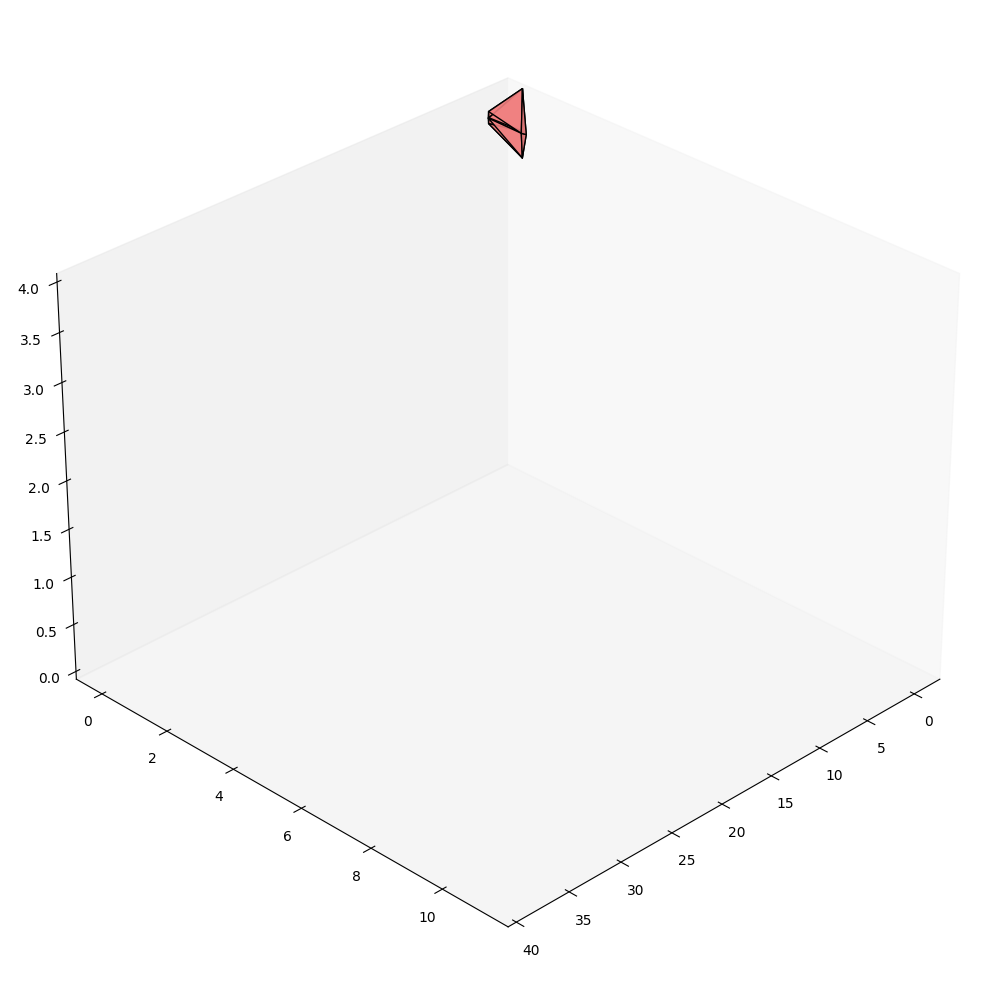

In [ ]:
# Add dependencies

# Set path
data_path:str = '/content/sample_data'
json_path:str = '/content/sample_data/segmentation_00000.json'

# 1. Lod image volume
ct_image = load_dicom_Series(data_path)
image_size = ct_image.GetSize()[:2] # width length
no_slices = ct_image.GetSize()[2]
# Product description
print("CT Size {}\nNo. Slices {}".format(ct_image.GetSize(), no_slices))

# 2. Load segmentation & create mask
mask_3d = parse_Segmentation(json_path, image_size, no_slices)

# 3. Extract nodule gra-level regon
nodule_volume = extract_nodule_Region(ct_image, mask_3d)


# 3.1 Down scale to the box of the actual nodule
cropped_nodule = crop_to_nodule_box(nodule_volume)

print("Volume shape ",nodule_volume.shape)
print("Non-zero voxel count ",np.count_nonzero(nodule_volume))
print("Value range ",np.min(nodule_volume), np.max(nodule_volume))

# 4. Rendering and Display
non_zero = nodule_volume[nodule_volume>0]
plot_3d(cropped_nodule, threshold=np.percentile(non_zero, 30))



In [ ]:
# Debugging
# Volume
print(nodule_volume.shape)
print(np.unique(nodule_volume))
print(len(np.unique(nodule_volume)))

# Thresholg against volume
print(np.min(nodule_volume), np.max(nodule_volume))
threshold = np.percentile(nodule_volume[nodule_volume>0], 30)

# Mask shape against ct's shape
mask_3d.shape == sitk.GetArrayFromImage(ct_image).shape

(103, 512, 512)
[-80 -77 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60
 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42
 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24
 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11  -8  -7  -2   0   1
   2   7   9  11  12  15  18  20  22  28  39  48  49  52  57  66  70  77
  80  82  85  86  92  93  98  99 100 102 103 104 107 108 109 114 116 117
 121 124 129]
111
-80 129


True

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git
